# Analyse full screening answers

This notebook has the purpose to
- clean and prepare the data coming from the MS forms sheet
- visualize and aggregate the research questions
- further analyse the dataset

In [2]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# # for printing issues
# pd.set_option('display.max_columns', None)  # or 1000
# pd.set_option('display.max_rows', None)  # or 1000
# pd.set_option('display.max_colwidth', None)  # or 199

In [3]:
# read in dataframe
df = pd.read_excel('..\data\Full Screening Questions (1-621)_reviewed.xlsx')

# strip strings in object columns
df_obj = df.select_dtypes(['object'])
df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

# check for multiple answers on the same paper
df = df.drop_duplicates(subset=['Number - Author Year'], keep='first')

print('df shape has ',df.shape)

df shape has  (610, 12)


## Clean and Prepare

In [4]:
# remove \n from strings
df.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=["",""], regex=True, inplace=True)

## How many papers have to be excluded for which reason?

In [6]:
df[df['Concrete medical supervised Machine Learning usecase?']=='No -> Exclude from review and submit form'].shape[0]

87

In [7]:
df[df['Which XAI method is used?']=='None -> Exclude from review and submit form;'].shape[0]

64

In [8]:
df[df['Tabular or Image data as input?']=='Text-> Exclude from review and submit form'].shape[0]

13

In [9]:
df[df['Tabular or Image data as input?']=='Audio-> Exclude from review and submit form'].shape[0]

0

In [5]:
# drop papers that have been excluded due to at least one of the following reasons
# - No concrete supervised medical machine learning use case
df = df[df['Concrete medical supervised Machine Learning usecase?']!='No -> Exclude from review and submit form']
# - No XAI method provided
df = df[df['Which XAI method is used?']!='None -> Exclude from review and submit form;']
# - No image or tabular data as input
df = df[df['Tabular or Image data as input?']!='Text-> Exclude from review and submit form']
df = df[df['Tabular or Image data as input?']!='Audio-> Exclude from review and submit form']

In [6]:
# check for missing values
authors_list = []
for row in df.index:
    df_row = df.loc[row, :]
    
    if pd.isnull(df_row).any():
        authors_list.append(df.loc[row, 'Number - Author Year'])

authors_list = list(set(authors_list))
sorted(authors_list)

[]

In [7]:
print('After dropping excluded papers, df shape is ',df.shape)

After dropping excluded papers, df shape is  (450, 12)


No missing values left - continue with granularisation of columns - "unroll" columns.

In [12]:
"""
# divide column 'Which XAI method is used?' into multiple columns:
df[['XAI_method_1', 'XAI_method_2', 'XAI_method_3', 'XAI_method_4', 'XAI_method_5']] = df['Which XAI method is used?'].str.split(";", expand = True)

# Problem: if "own method" is selected, now the description of this method might be in the next column
#'XAI_method_5' could be deleted again, because contains no information - only None values
"""

def used_methods_value_count(df):
    """Performs a value count on which method is used? Excludes own developed methods"""
    
    # drop all rows with substring "Own method developed"
    df = df[~df['Which XAI method is used?'].str.contains('Own method developed')]

    # Perform value counts on remaining methods
    ser = df['Which XAI method is used?'].str.split(";", expand=True).stack(dropna=True).value_counts()
    
    # drop the first line as this is a value counts of None
    ser = ser.drop(labels=[''])
    
    # alter index for better readability
    ser.rename(index={'Model is intrinsic interpretable (i.e., decision tree or linear regression)':'Intrinsic interpretable'},
              inplace=True)
    
    return ser

ser = used_methods_value_count(df)

print('Top 20 most used XAI methods')
ser[:20]

Top 20 most used XAI methods


SHAP                                                                                      119
Intrinsic interpretable                                                                    94
Class Activation Mapping or related (i. e., Grad-CAM)                                      92
Random Forest Feature Importance                                                           46
LIME                                                                                       40
Partial Dependence Plots                                                                   14
Layer-Wise Relevance Propagation                                                            9
Permutation Importance                                                                      5
DeepLift                                                                                    3
Attention Mechanism                                                                         3
Saliency Maps                                               

In [13]:
# How many methods in total that are not self-developed?
ser.sum()

490

In [14]:
# How many self developed methods?
ser['Own method developed'] = df['Which XAI method is used?'].str.contains('Own method developed').sum()
ser = ser.sort_values(ascending=False)
ser['Own method developed']

45

In [15]:
# How many explanations methods per paper on average?
ser.sum()/df.shape[0]

1.1888888888888889

## Which XAI methods have been used the most?

In [16]:
# Explanation methods by data input
df_tab = df[df['Tabular or Image data as input?']=='Tabular (includes EEG, ECG, time-series data)']
df_img = df[df['Tabular or Image data as input?']=='Image data (includes video data)']

ser_tab = used_methods_value_count(df_tab).rename('tabular')
ser_img = used_methods_value_count(df_img).rename('image')

df_tab_img = pd.concat([ser_tab, ser_img], 
                       names=['tabular', 'image'], 
                       axis='columns')

# replace NaNs
df_tab_img=df_tab_img.fillna(0)

# drop methods that have been used less than 3 times
df_tab_img = df_tab_img[(df_tab_img.tabular>2) | (df_tab_img.image>2)]

df_tab_img

,tabular,image
SHAP,108.0,11.0
Intrinsic interpretable,90.0,4.0
Random Forest Feature Importance,41.0,5.0
LIME,27.0,13.0
Partial Dependence Plots,14.0,0.0
"Class Activation Mapping or related (i. e., Grad-CAM)",8.0,84.0
Permutation Importance,5.0,0.0
Layer-Wise Relevance Propagation,3.0,6.0
Saliency Maps,0.0,3.0


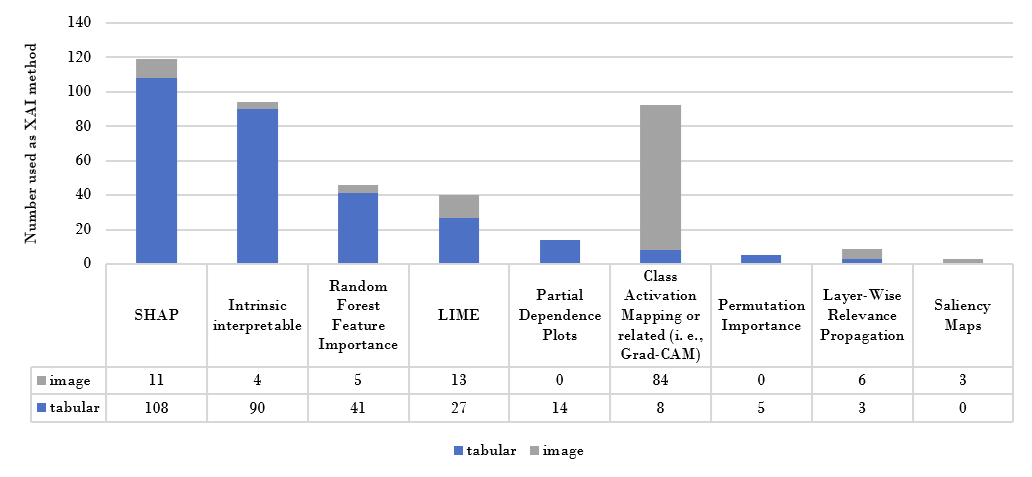

## Which data input type is more common?

In [18]:
df['Tabular or Image data as input?'].value_counts()

Tabular (includes EEG, ECG, time-series data)    307
Image data (includes video data)                 143
Name: Tabular or Image data as input?, dtype: int64

In [19]:
df['Tabular or Image data as input?'].value_counts(normalize=True)

Tabular (includes EEG, ECG, time-series data)    0.682222
Image data (includes video data)                 0.317778
Name: Tabular or Image data as input?, dtype: float64

Tabular data is still the most used format for ML applications. They're used twice as much as image applications.

In [17]:
# Prepare for big result_df
res_df=pd.DataFrame()

## What is the distribution of the publication years?

In [18]:
df['pub_year']=df['Number - Author Year'].str.split(' ', expand=True).loc[:, 3]
res = df['pub_year'].value_counts().sort_index()
res.loc['2008-2019']=res[(res.index >= '2008') & (res.index <= '2019')].sum()
res = res.drop(['2008', '2009', '2010', '2011', '2012', '2014', '2015', '2016', '2017',
       '2018', '2019'], axis='index')
res = res.reindex(['2008-2019', '2020', '2021', '2022'])
res_df['publications_count'] = res
res_df

,publications_count
2008-2019,79
2020,108
2021,200
2022,63


Exponential growth in publications!

## Do the ML pipeline descriptions improve over time?

In [22]:
res = df.groupby('pub_year').mean()['How well is the Machine Learning pipeline described? (1 = Not Described, 3 = Elaborately described)']
res.loc['2008-2019']=res[(res.index >= '2008') & (res.index <= '2019')].mean()
res = res.drop(['2008', '2009', '2010', '2011', '2012', '2014', '2015', '2016', '2017',
       '2018', '2019'], axis='index')
res = res.reindex(['2008-2019', '2020', '2021', '2022'])
res_df['Mean of ML pipeline evaluation'] = res
res_df

,publications_count,Mean of ML pipeline evaluation
2008-2019,79,1.869501
2020,108,2.148148
2021,200,2.155000
2022,63,2.301587


In [23]:
print('Mean ML pipeline ', 
      df['How well is the Machine Learning pipeline described? (1 = Not Described, 3 = Elaborately described)'].std())
print('Std  ML pipeine ',
      df['How well is the Machine Learning pipeline described? (1 = Not Described, 3 = Elaborately described)'].mean())

Mean ML pipeline  0.600156706418699
Std  ML pipeine  2.151111111111111


## How does the `code` sharing ratio change over time?

In [19]:
def grp_by_year_and_count(df, col):
    """
    Groups dataframe by publication year and counts instances of a column.
    Returns normalized and absolute values dataframe as df_abs, df_norm
    """
    

    res = df.groupby(['pub_year', col]).size().unstack(fill_value=0)
    res.loc['2008-2019', :]=res[(res.index >= '2008') & (res.index <= '2019')].sum()
    for year in ['2008', '2009', '2010', '2011', '2012', '2014', '2015', '2016', '2017',
           '2018', '2019']:
        try:
            res = res.drop([year], axis='index')
        except:
            print(f'{year} not in axis!')
            continue
    
    res = res.reindex(['2008-2019', '2020', '2021', '2022'])
    res_norm = res.div(res.sum(axis=1), axis=0)
    
    return res, res_norm

In [35]:
res, res_norm = grp_by_year_and_count(df, 'Source Code provided?')
res_df = pd.concat([res_df, 
                    res.add_prefix('code_abs_')], 
                   axis=1)
res_df = pd.concat([res_df, 
                    res_norm.add_prefix('code_norm_')], 
                   axis=1)

In [ ]:
df['Source Code provided?'].value_counts(normalize=True)

## How does the `data` sharing ratio change over time?

In [37]:
res, res_norm = grp_by_year_and_count(df, 'Data available?')
res_df = pd.concat([res_df, 
                    res.add_prefix('data_abs_')], 
                   axis=1)
res_df = pd.concat([res_df, 
                    res_norm.add_prefix('data_norm_')], 
                   axis=1)

In [38]:
res_df.to_csv('..\\plots\\tables\\pub_count_ml_pipeline_code_data_sharing_eval.csv',
             index_label='pub_year')

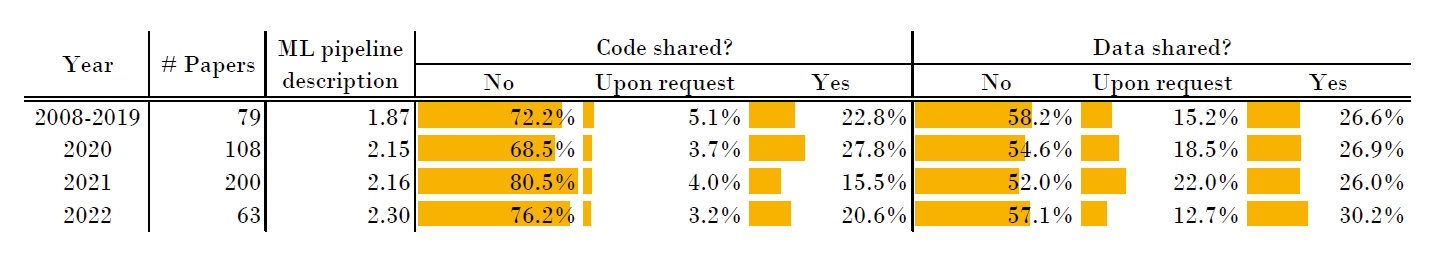

### Added: Overall ml pipeline mean, code shared?, data shared?

In [24]:
#ml description mean+ code provided? + data shared? (overall)
df['How well is the Machine Learning pipeline described? (1 = Not Described, 3 = Elaborately described)'].mean()

2.151111111111111

In [26]:
#percentage code provided overall
df['Source Code provided?'].value_counts(normalize=True)

No              0.755556
Yes             0.204444
Upon request    0.040000
Name: Source Code provided?, dtype: float64

In [27]:
#percentage data shareed overall
df['Data available?'].value_counts(normalize=True)

No              0.544444
Yes             0.268889
Upon request    0.186667
Name: Data available?, dtype: float64

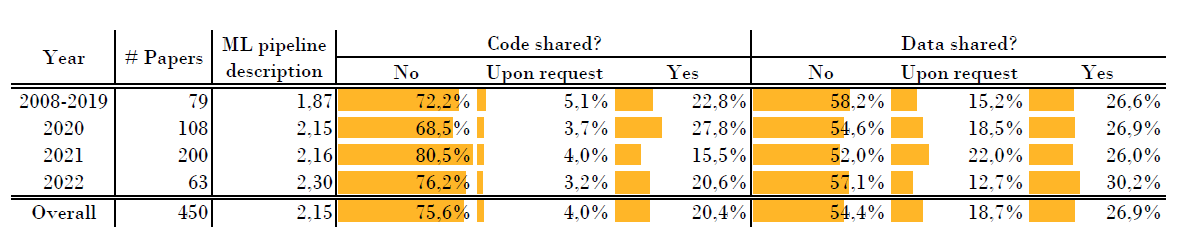

## Does the input type change over time?

In [39]:
res, res_norm = grp_by_year_and_count(df, 'Tabular or Image data as input?')
res_norm

Tabular or Image data as input?,Image data (includes video data),"Tabular (includes EEG, ECG, time-series data)"
pub_year,,
2008-2019,0.202532,0.797468
2020,0.324074,0.675926
2021,0.315000,0.685000
2022,0.460317,0.539683


Clear trend towards image data due to increased computational power and availability of image data.

## What is the code and data sharing ratio for own developed methods?

In [40]:
filt = df['Which XAI method is used?'].str.contains('Own method developed')
res, res_norm = grp_by_year_and_count(df[filt], 'Source Code provided?')

2008 not in axis!
2010 not in axis!


In [42]:
res_norm

Source Code provided?,No,Upon request,Yes
pub_year,,,
2008-2019,0.933333,0.000000,0.066667
2020,0.533333,0.133333,0.333333
2021,0.545455,0.090909,0.363636
2022,0.500000,0.250000,0.250000


In [44]:
res, res_norm = grp_by_year_and_count(df[~filt], 'Source Code provided?')

In [46]:
res_norm

Source Code provided?,No,Upon request,Yes
pub_year,,,
2008-2019,0.671875,0.062500,0.265625
2020,0.709677,0.021505,0.268817
2021,0.820106,0.037037,0.142857
2022,0.779661,0.016949,0.203390


The willingness to share source code is 4.4 % points higher for own develop explanation methods.

## Who is able to understand the explanation method? To whom are the explanations of the AI system addressed?

In [77]:
ser = pd.Series(df['Who is potentially able to understand the XAI method?'].apply(lambda x: x.split(';')))
ser = pd.Series([x for item in ser for x in item])
ser[ser!=''].value_counts()/450

Developers (Data Scientists or ML Engineers)    1.000000
Domain experts                                  0.904444
Patiensts                                       0.164444
Other stakeholders not mentioned above          0.148889
dtype: float64

### Which explanation methods are understood by patients?

In [42]:
# filter patients
filt = df['Who is potentially able to understand the XAI method?'].str.contains('Patiensts')
df_pat = df[filt]
df_npat = df[~filt]

ser_pat = used_methods_value_count(df_pat).rename('Understood by patients')
ser_npat = used_methods_value_count(df_img).rename('Not understood by patients') 
                ### müsste hier oberhalb nicht ..(df_npat).rename... stehen?--> die Zahlen in der 
                ### untenstehenden Grafik passen in Summe auch nicht zu den Zahlen in der Tabelle *Anzahl Verwendung XAI Methode*

df_pat_npat = pd.concat([ser_pat, ser_npat], 
                       names=['Understood by patients', 
                              'Not understood by patients'], 
                       axis='columns')

# replace NaNs
df_pat_npat=df_pat_npat.fillna(0)

# drop methods that have been used less than 3 times
filt2=(df_pat_npat['Understood by patients']>2) | (df_pat_npat['Not understood by patients']>2)
df_pat_npat = df_pat_npat[filt2]

In [ ]:
df_pat_npat

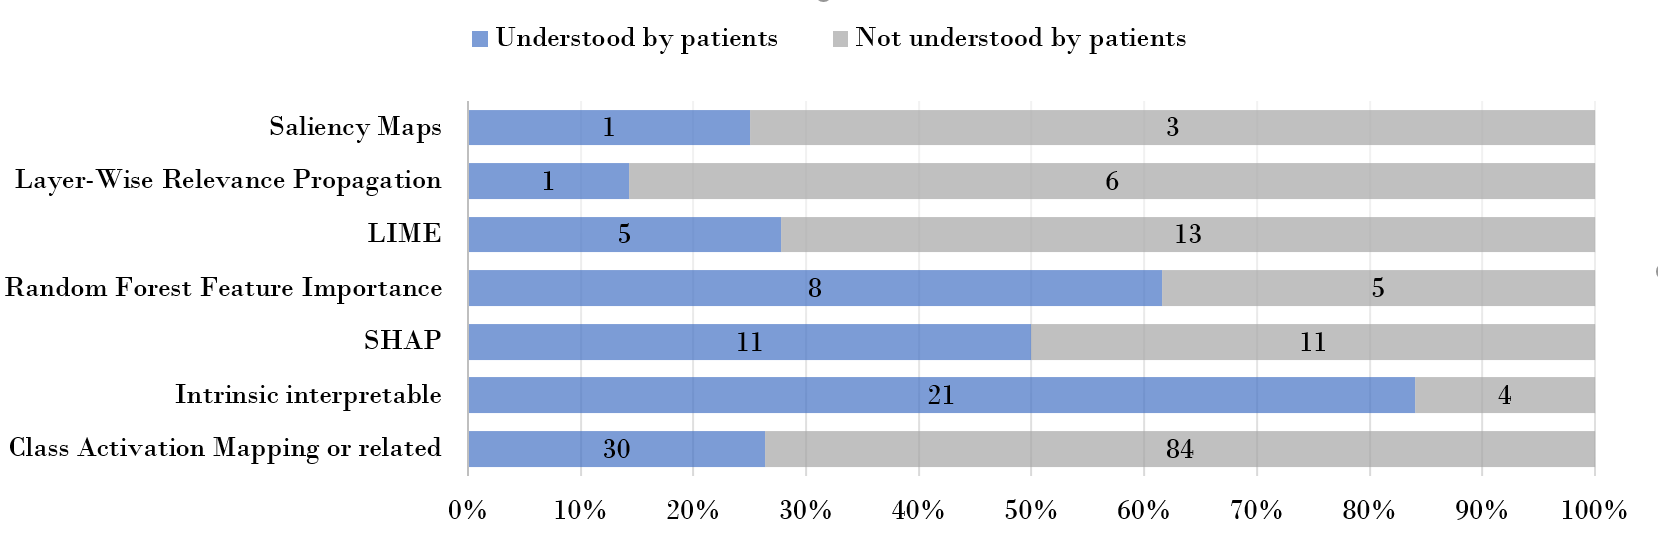

### Difference in tabular and image data, XAI understood by patients?

In [53]:
df_pat.groupby(['Tabular or Image data as input?']).size().reset_index(name='counts')

,Tabular or Image data as input?,counts
0,Image data (includes video data),36
1,"Tabular (includes EEG, ECG, time-series data)",38


In [52]:
df_npat.groupby(['Tabular or Image data as input?']).size().reset_index(name='counts')

,Tabular or Image data as input?,counts
0,Image data (includes video data),107
1,"Tabular (includes EEG, ECG, time-series data)",269


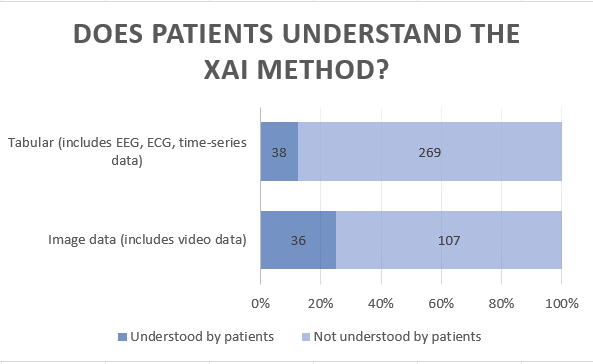

### Difference ML description tabular and image data?

In [54]:
df.groupby(['Tabular or Image data as input?',
           'How well is the Machine Learning pipeline described? (1 = Not Described, 3 = Elaborately described)']).size().reset_index(name='counts')

,Tabular or Image data as input?,"How well is the Machine Learning pipeline described? (1 = Not Described, 3 = Elaborately described)",counts
0,Image data (includes video data),1.0,7
1,Image data (includes video data),2.0,92
2,Image data (includes video data),3.0,44
3,"Tabular (includes EEG, ECG, time-series data)",1.0,45
4,"Tabular (includes EEG, ECG, time-series data)",2.0,186
5,"Tabular (includes EEG, ECG, time-series data)",3.0,76


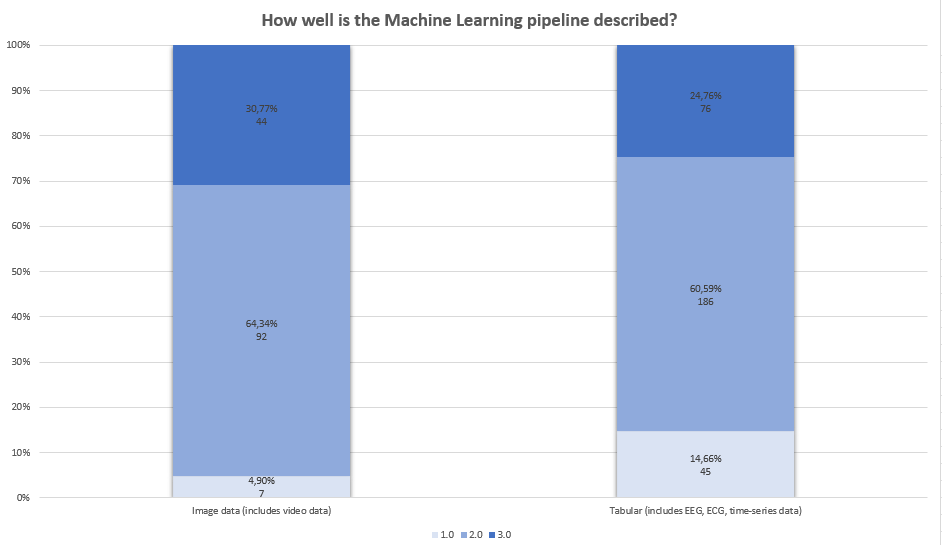

### Difference code and data availability in tabular and image data?

### Difference in description of ml pipeline based on XAI method?

### Differences in code/data availablity based on XAI method used?

### Which XAI methods mostly used in specific years? Distribution of XAI methods over time